In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('wine_clean.csv')

In [18]:
df.head()

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119958 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119958 non-null  object 
 6   region_1               101186 non-null  object 
 7   taster_name            95071 non-null   object 
 8   taster_twitter_handle  90542 non-null   object 
 9   title                  119988 non-null  object 
 10  variety                119987 non-null  object 
 11  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 11.0+ MB


In [20]:
df.isnull().sum()

country                     30
description                  0
designation              34545
points                       0
price                     8395
province                    30
region_1                 18802
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

Ajustes finais

In [21]:
df['price'] = df.groupby(['country', 'points'])['price'].transform(lambda x: x.fillna(x.median()))

In [22]:
pricena = df.loc[df.price.isna()].index
df.drop(index = pricena, inplace= True)
df.isnull().sum()

country                      0
description                  0
designation              34540
points                       0
price                        0
province                     0
region_1                 18770
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

Criando o modelo de Regressão linear com os dados não tão limpos

In [23]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=42)

len(df_full_train), len(df_train), len(df_val), len(df_test)

(95964, 71973, 23991, 23992)

In [24]:
# Target variables
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

Aplicando One-hot Encoding

In [25]:
from sklearn.feature_extraction import DictVectorizer
features= ['points', 'country', 'province']
dv = DictVectorizer(sparse= True)
# Transformando as features na matrix X
train_dicts = df_train[features].to_dict(orient= 'records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[features].to_dict(orient= 'records')
X_val = dv.transform(val_dicts)

In [26]:
from sklearn.linear_model import LinearRegression
# Treinando o modelo
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

/home/marcus-vinicius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/marcus-vinicius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

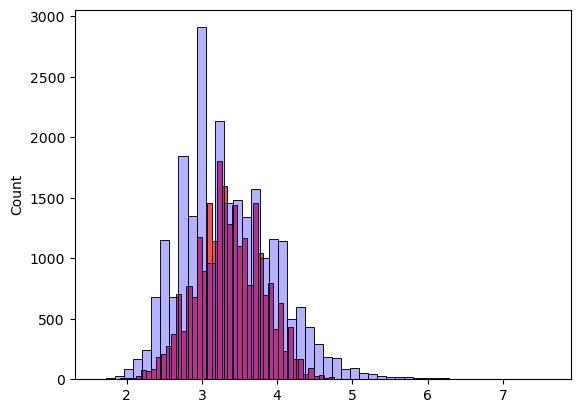

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(y_pred, color= 'red', alpha= 0.7, bins= 50)
sns.histplot(y_val, color= 'blue', alpha= 0.3, bins= 50)

In [28]:
# Obter as previsões na escala de real
y_pred_orig = np.expm1(y_pred) 
# Obter o valor real (target):
y_val_orig= np.expm1(y_val)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cálculo do MAE
mae = mean_absolute_error(y_val_orig, y_pred_orig)
print(f"MAE (Erro Absoluto Médio): ${mae:.2f}")

# Cálculo do RMSE
rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
print(f"RMSE (Raiz do Erro Quadrático Médio): ${rmse:.2f}")

MAE (Erro Absoluto Médio): $13.30
RMSE (Raiz do Erro Quadrático Médio): $32.63


/home/marcus-vinicius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/marcus-vinicius/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

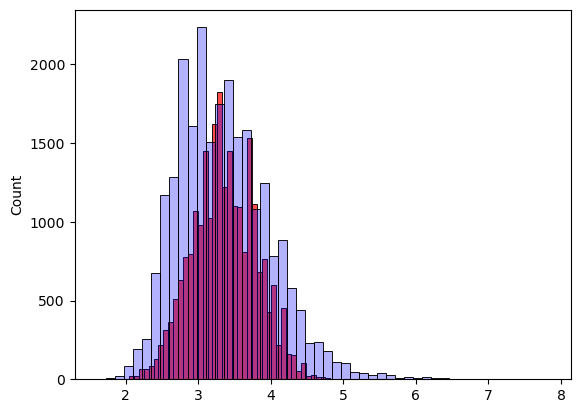

In [30]:
test_dicts = df_test[features].to_dict(orient= 'records')
X_test = dv.transform(test_dicts)
y_pred_test = model.predict(X_test)

sns.histplot(y_pred_test, color= 'red', alpha= 0.7, bins= 50)
sns.histplot(y_test, color= 'blue', alpha= 0.3, bins= 50)

In [31]:
# Obter as previsões na escala de real
y_pred_orig = np.expm1(y_pred_test) 
# Obter o valor real (target):
y_test_orig= np.expm1(y_test)

# Cálculo do MAE
mae = mean_absolute_error(y_test_orig, y_pred_orig)
print(f"MAE (Erro Absoluto Médio): ${mae:.2f}")

# Cálculo do RMSE
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
print(f"RMSE (Raiz do Erro Quadrático Médio): ${rmse:.2f}")

MAE (Erro Absoluto Médio): $13.92
RMSE (Raiz do Erro Quadrático Médio): $38.04
